<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install pingouin > /dev/null 2>&1
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import itertools
from IPython.display import Image
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import ttest_rel
from statsmodels.stats.power import TTestPower

warnings.filterwarnings("ignore")

In [4]:
# @title Figure 2A
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%202A.png?raw=true', width=700)

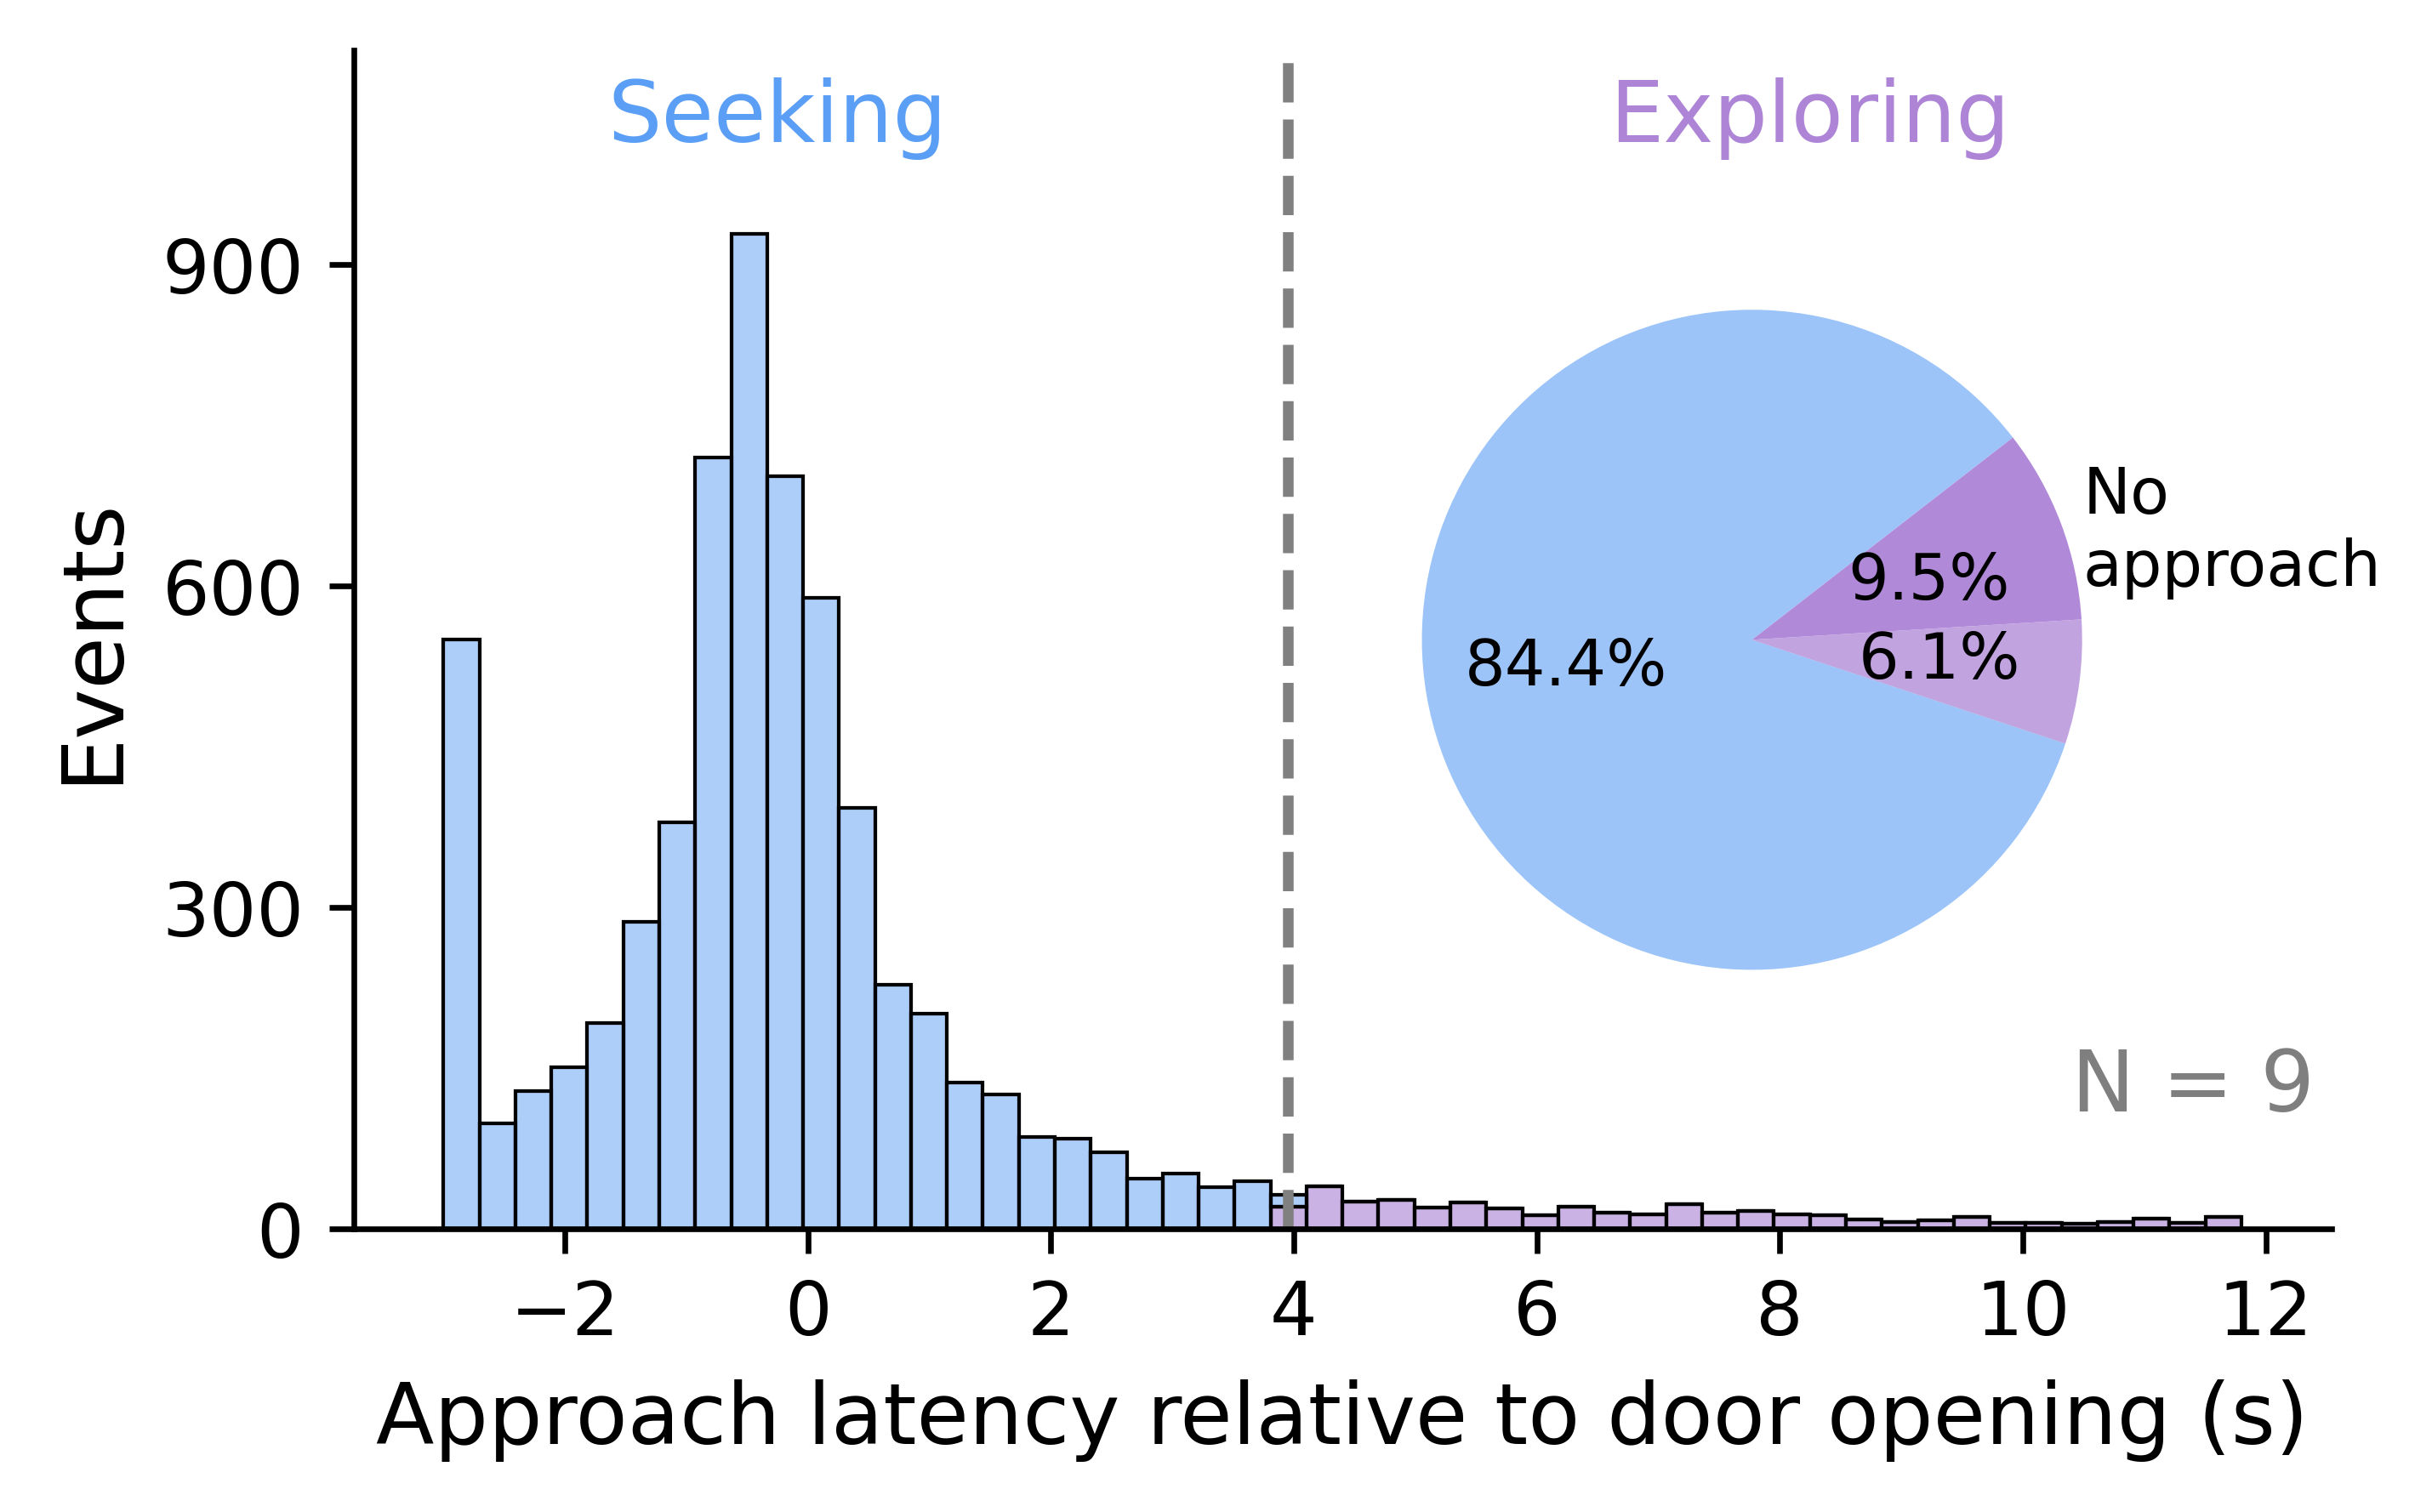

In [ ]:
# @title Figure 1B
data = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/all_DOORs_Figure2.csv")
event_social = data.query('mode == "social"')
# Define categories based on approachtime2
conditions = [
    (event_social['approachtime2'] < 4),
    (event_social['approachtime2'] >= 4) & (event_social['approachtime2'] <= 12),
    (event_social['approachtime2'] > 12)
]
labels = ['Seeking', 'Exploring', 'No approaching']
colors = ['#5A9EF599', '#9966CC99', '#b189d9']

event_social['approach_category'] = np.select(conditions, labels, default='No approaching')

# Count and percentage
approach_counts = event_social['approach_category'].value_counts()
approach_percent = approach_counts / approach_counts.sum() * 100

fig= plt.figure(figsize= (5,3), dpi=600)
partial = event_social.query('approachtime2<12.1')
ax = sns.histplot(
    data=partial,
    x='approachtime2',
    hue='approach_category',
    bins=50,
    stat='count',
    multiple='stack',
    palette={'Seeking': '#5A9EF599', 'Exploring': '#9966CC99', 'No approaching': '#b189d9'},
    alpha=0.5
)
ax.legend([],[], frameon=False)
sns.despine()
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.text(0.93, 0.12,f"N = {len(partial['device_number'].unique())}",fontsize = 12, alpha=0.5, va='center',ha='center', transform=ax.transAxes)
plt.axvline(x = 3.95, linestyle = "--", color = 'grey')
plt.text(-.25, 1015, "Seeking", horizontalalignment='center', color='#5A9EF5', fontsize = 12)
plt.text(8.25, 1015, "Exploring", horizontalalignment='center', color='#9966CC', alpha = 0.8, fontsize=12)#E6A624
plt.ylabel('Events', fontsize = 12)
plt.yticks(fontsize = 10.5)
plt.xticks(fontsize = 10.5)
plt.ylim(0, 1100)
plt.xlabel('Approach latency relative to door opening (s)', fontsize = 12)

# Plot updated pie chart in inset
inset_ax = inset_axes(ax, width="55%", height="50%", loc='center right')
# Prepare values and color mapping
values = [approach_counts[label] for label in labels]
colors_map = dict(zip(labels, colors))
total = sum(values)

# Plot pie chart without autopct or labels
wedges, texts = inset_ax.pie(
    values,
    colors=[colors_map[label] for label in labels],
    labels=[""] * len(labels),
    startangle=37.8,
    radius=1.4,  # Increase this to make the pie larger
    textprops={'fontsize': 9, 'ha': 'center', 'va': 'center'}
)

# Add percent text for all segments, and external label only for "No approaching"
for i, (wedge, value, label) in enumerate(zip(wedges, values, labels)):
    angle = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    # Add percent inside the pie
    pct = value / total * 100
    inset_ax.text(x * 0.8, y * 0.7, f"{pct:.1f}%", ha='center', va='center', fontsize=9)

    # For "No approaching", also add wrapped label outside
    if label == "No approaching":
        inset_ax.text(x * 1.5, y * 1.3, "No\napproach", ha='left', va='center', fontsize=9)

One-way ANOVA:
Seeking
  Source            SS  DF           MS           F         p-unc       ng2  \
0   mode  10655.691749   2  5327.845874  143.488921  6.048851e-11  0.829694   
1  Error    594.091399  16    37.130712         NaN           NaN       NaN   

        eps  
0  0.914438  
1       NaN  
Exploring
  Source          SS  DF         MS         F     p-unc       ng2       eps
0   mode   19.984229   2   9.992114  0.254551  0.778345  0.020154  0.725088
1  Error  628.062998  16  39.253937       NaN       NaN       NaN       NaN

Posthoc:
Seeking
  Contrast           A           B  Paired  Parametric          T  dof  \
0     mode       empty  extinction    True        True  -5.535224  8.0   
1     mode       empty      social    True        True -19.969571  8.0   
2     mode  extinction      social    True        True -10.206606  8.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  5.504389e-04  5.504389e-04     holm     67.429 -1.88165

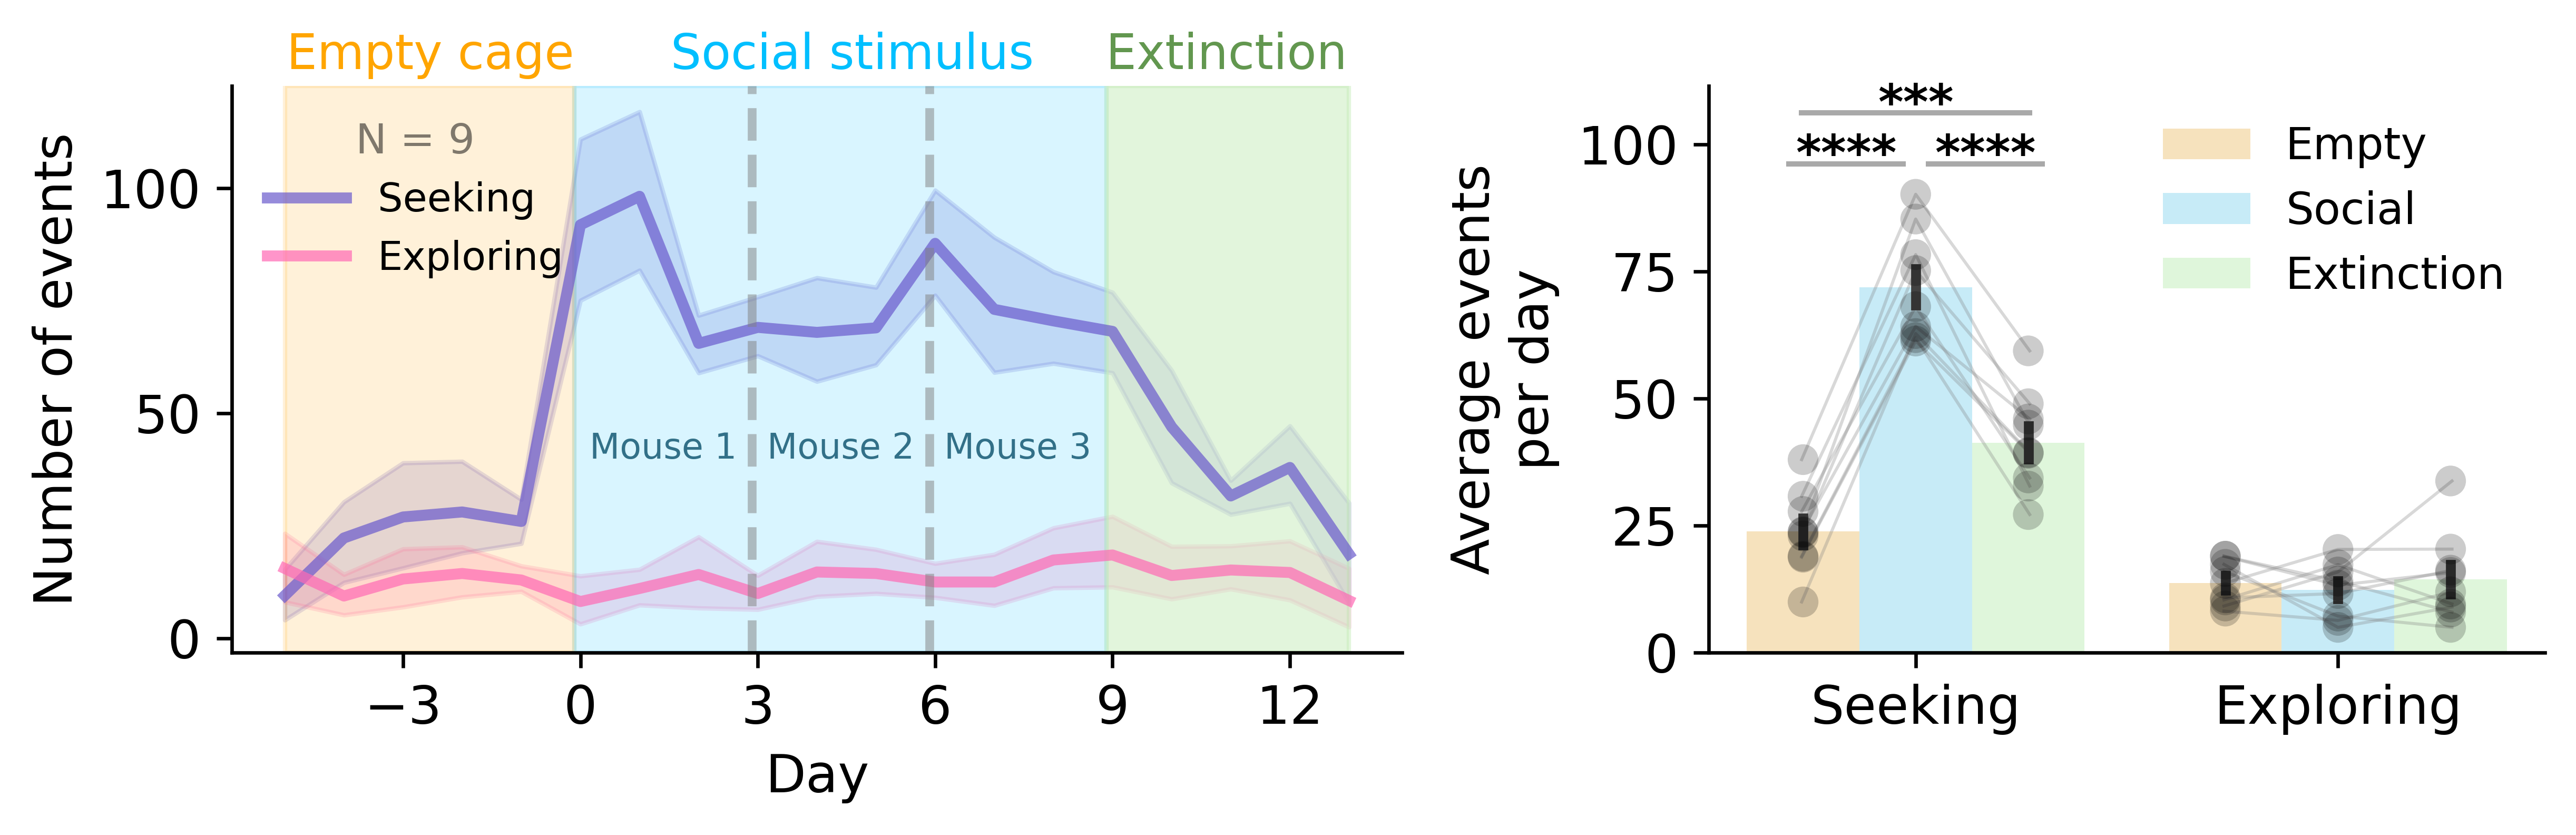

In [ ]:
# @title Figure 1C-D
a = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/all_DOORs_Figure2.csv")
a['day'] = (pd.to_datetime(a["datetime"], format='mixed') - pd.to_datetime("2024-10-16 15:30:00")).dt.days
a['day'] = a['day'].where(a["device_number"] < 10, (pd.to_datetime(a["datetime"], format='mixed') - pd.to_datetime("2024-11-9 14:30:00")).dt.days)
b = a.groupby(['day','device_number','behavior'])['event'].count().reset_index()
b = b.query('day > -6 and day < 14')

# Generate all combinations
days = b['day'].unique()
device_numbers = b['device_number'].unique()
behaviors = b['behavior'].unique()
all_combinations = pd.DataFrame(list(itertools.product(days, device_numbers, behaviors)), columns=['day', 'device_number','behavior'])

b_filled = all_combinations.merge(b, on=['day', 'device_number','behavior'], how='left')
b_filled['event'] = b_filled['event'].fillna(0).astype(int)
b = b_filled.sort_values(['device_number', 'day','behavior']).reset_index(drop=True)
b['sex'] = b['device_number'].apply(lambda x: 'm' if x in [0, 1, 2, 3, 10, 11, 12] else 'f')

# Prepare barplot data
pp = a.query('day > -6 and day < 14 and device_number not in [0, 2, 3, 5, 6, 8]')
c = pp.groupby(["device_number",'mode',"day","behavior"])["event"].count().reset_index()
cc = c.groupby(['device_number','mode',"behavior"])['event'].mean().reset_index()

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(8.25, 2.75), dpi=600, gridspec_kw={'width_ratios': [1.4, 1]})

# ===== First Plot: Lineplot =====
sns.lineplot(ax=axes[0], data=b, x='day', y='event', hue='behavior',
             linewidth=2.5, palette={"Seeking": "slateblue", "Exploring": "hotpink"},
             alpha=0.7, hue_order=['Seeking','Exploring'])
axes[0].axvspan(b['day'].min(), -0.1, color='orange', alpha=0.15)
axes[0].axvspan(-0.1, min(b['day'].max(), 8.9), color='deepskyblue', alpha=0.15)
axes[0].axvspan(8.9, b['day'].max(), color='#C7ECBA', alpha=0.5)
axes[0].axvline(2.9, linestyle='--', color='gray', alpha=0.5, linewidth=2)
axes[0].axvline(5.9, linestyle='--', color='gray', alpha=0.5, linewidth=2)
axes[0].text(0.17, 1.03, "Empty cage", fontsize=11, color='orange', ha='center', transform=axes[0].transAxes)
axes[0].text(0.53, 1.03, "Social stimulus", fontsize=11, color='deepskyblue', ha='center', transform=axes[0].transAxes)
axes[0].text(0.85, 1.03, "Extinction", fontsize=11, color='#3B7D23', alpha=0.8, ha='center', transform=axes[0].transAxes)
axes[0].text(1.4, 40, "Mouse 1", fontsize=8, color='#084F6A', alpha=0.8, ha='center')
axes[0].text(4.4, 40, "Mouse 2", fontsize=8, color='#084F6A', alpha=0.8, ha='center')
axes[0].text(7.4, 40, "Mouse 3", fontsize=8, color='#084F6A', alpha=0.8, ha='center')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Number of events', fontsize=12)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].yaxis.set_major_locator(MaxNLocator(3))
axes[0].xaxis.set_major_locator(MaxNLocator(7))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
legend = axes[0].legend(title=f'N = {len(b["device_number"].unique())}', fontsize=9, title_fontsize=9.5, loc='upper left', frameon=False)
legend.get_title().set_alpha(0.5)

# ===== Second Plot: Barplot with strip and connecting lines =====
interaction_order = ["Seeking", "Exploring"]
mode_order = ["empty", "social", "extinction"]
x_positions = {"Seeking": 0, "Exploring": 1}
mode_offsets = {"empty": -0.27, "social": 0.0, "extinction": 0.27}

def add_sig_line(ax, x1, x2, y, p_val, h=1):
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.plot([x1, x2], [y + h, y + h], lw=1.2, c='darkgray')
    ax.text((x1 + x2) / 2, y + h + 1.5, stars, ha='center', va='center', fontsize=11,fontweight='bold')

# Run stats
aov_results = {}
posthoc_results = {}

for behavior in cc['behavior'].unique():
    df_behavior = cc[cc['behavior'] == behavior]
    if df_behavior['mode'].nunique() < 2 or df_behavior['device_number'].nunique() < 2:
        continue
    try:
        aov = pg.rm_anova(dv='event', within='mode', subject='device_number',
                          data=df_behavior, detailed=True)
        posthoc = pg.pairwise_ttests(dv='event', within='mode', subject='device_number',
                                     data=df_behavior, padjust='holm', parametric=True)
        aov_results[behavior] = aov
        posthoc_results[behavior] = posthoc
    except Exception as e:
        print(f"Failed on {behavior}: {e}")
print("One-way ANOVA:\nSeeking")
print(aov_results['Seeking'])
print("Exploring")
print(aov_results['Exploring'])
print("\nPosthoc:\nSeeking")
print(posthoc_results['Seeking'])
print("Exploring")
print(posthoc_results['Exploring'])
# Plot bars
sns.barplot(
    ax=axes[1],
    data=cc,
    x="behavior",
    y="event",
    hue="mode",
    errorbar="se", capsize=0,
    order=interaction_order,
    hue_order=mode_order,
    palette={"empty": "#FFE5B4", "social": "#BFEFFF", "extinction": "#DCFAD7"}
)

sns.stripplot(
    ax=axes[1],
    data=cc,
    x="behavior",
    y="event",
    hue="mode",
    dodge=True, jitter=False,
    palette=['black'] * 4, alpha=0.2, size=7,
    order=interaction_order,
    hue_order=mode_order,
    legend=False
)

# Connect points per animal
for behavior in interaction_order:
    sub_data = cc[cc["behavior"] == behavior]
    for device in sub_data["device_number"].unique():
        device_data = sub_data[sub_data["device_number"] == device]
        if device_data.shape[0] < 2:
            continue
        device_data = device_data.copy()
        device_data['x'] = device_data['mode'].map(mode_offsets) + x_positions[behavior]
        device_data = device_data.sort_values('x')
        axes[1].plot(
            device_data['x'].values,
            device_data['event'].values,
            color="gray", linestyle="-", linewidth=0.7, alpha=0.3, zorder=1
        )

# Annotate significance with clear horizontal jitter and vertical levels
for behavior in interaction_order:
    if behavior not in posthoc_results:
        continue

    x_base = x_positions[behavior]
    posthoc = posthoc_results[behavior]
    y_max = cc[cc['behavior'] == behavior]['event'].max()

    # Define pairwise comparisons and their horizontal shifts
    comparisons = [
        ("empty", "social"),       # lower level
        ("social", "extinction"),  # lower level
        ("empty", "extinction"),   # higher level
    ]
    x_shifts = [-0.03, 0.03, 0]  # left, right, center

    # Define vertical heights: use same height for 1st & 2nd, higher for 3rd
    base_y = y_max + 5
    heights = [base_y, base_y, base_y + 10]

    for ((cond1, cond2), x_shift, y) in zip(comparisons, x_shifts, heights):
        subset = posthoc[((posthoc['A'] == cond1) & (posthoc['B'] == cond2)) |
                         ((posthoc['A'] == cond2) & (posthoc['B'] == cond1))]
        if not subset.empty:
            p_val = subset.iloc[0].get('p-corr', subset.iloc[0]['p-unc'])
            x1 = x_base + mode_offsets[cond1] + x_shift
            x2 = x_base + mode_offsets[cond2] + x_shift
            add_sig_line(axes[1], x1, x2, y, p_val)



# Formatting
axes[1].set_ylabel("Average events\nper day", fontsize=12)
axes[1].set_xlabel("")
axes[1].set_xticklabels([label.get_text().capitalize() for label in axes[1].get_xticklabels()])
axes[1].tick_params(axis='both', labelsize=12)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
sns.despine(ax=axes[1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[:3], labels=["Empty", "Social",'Extinction'],
           fontsize=10, frameon=False, loc="upper right")

plt.tight_layout()
plt.show()